In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torch.nn.functional import normalize

In [11]:
class SimCLRTransform:
    def __init__(self, size=32):
        self.transform = transforms.Compose([
            transforms.RandomResizedCrop(size=size),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
        ])

    def __call__(self, x):
        return self.transform(x), self.transform(x)

In [12]:
train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=SimCLRTransform())
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=4)

Files already downloaded and verified


In [13]:
class ProjectionHead(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ProjectionHead, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm1d(hidden_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [14]:
class SimCLR(nn.Module):
    def __init__(self, base_model, projection_dim=128):
        super(SimCLR, self).__init__()
        self.base_model = nn.Sequential(*list(base_model.children())[:-1])
        self.projection_head = ProjectionHead(512, 256, projection_dim)

    def forward(self, x):
        h = self.base_model(x).squeeze()
        z = self.projection_head(h)
        return normalize(z, dim=1)

In [15]:
class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(NTXentLoss, self).__init__()
        self.temperature = temperature

    def forward(self, z_i, z_j):
        z = torch.cat([z_i, z_j], dim=0)
        similarity_matrix = torch.mm(z, z.T)
        batch_size = z_i.size(0)

        labels = torch.cat([torch.arange(batch_size) for _ in range(2)], dim=0)
        labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float().to(z.device)

        mask = torch.eye(labels.shape[0], dtype=torch.bool).to(z.device)
        labels = labels[~mask].view(labels.shape[0], -1)
        similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1)

        positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1)
        negatives = similarity_matrix[~labels.bool()].view(labels.shape[0], -1)

        logits = torch.cat([positives, negatives], dim=1)
        labels = torch.zeros(logits.shape[0], dtype=torch.long).to(z.device)

        logits = logits / self.temperature
        loss = nn.CrossEntropyLoss()(logits, labels)
        return loss

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimCLR(models.resnet18(pretrained=False), projection_dim=128).to(device)
criterion = NTXentLoss(temperature=0.5)
optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-4)

In [17]:
from tqdm import tqdm

num_epochs = 10
epoch_loss = []
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    print(f"Epoch [{epoch + 1}/{num_epochs}]")

    with tqdm(total=len(train_loader), desc="Training", unit="batch") as progress_bar:
        for (x_i, x_j), _ in train_loader:
            x_i, x_j = x_i.to(device), x_j.to(device)

            z_i = model(x_i)
            z_j = model(x_j)

            loss = criterion(z_i, z_j)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            progress_bar.set_postfix(loss=f"{loss.item():.4f}")
            progress_bar.update(1)

    avg_loss = total_loss / len(train_loader)
    epoch_loss.append(avg_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] Completed, Average Loss: {avg_loss:.4f}")

print("Training complete.")

Epoch [1/10]


Training: 100%|██████████| 196/196 [01:24<00:00,  2.33batch/s, loss=4.2693]


Epoch [1/10] Completed, Average Loss: 5.4986
Epoch [2/10]


Training: 100%|██████████| 196/196 [01:24<00:00,  2.33batch/s, loss=4.1104]


Epoch [2/10] Completed, Average Loss: 5.3221
Epoch [3/10]


Training: 100%|██████████| 196/196 [01:21<00:00,  2.40batch/s, loss=4.1313]


Epoch [3/10] Completed, Average Loss: 5.2656
Epoch [4/10]


Training: 100%|██████████| 196/196 [01:22<00:00,  2.37batch/s, loss=4.0407]


Epoch [4/10] Completed, Average Loss: 5.2346
Epoch [5/10]


Training: 100%|██████████| 196/196 [01:22<00:00,  2.38batch/s, loss=3.9371]


Epoch [5/10] Completed, Average Loss: 5.2043
Epoch [6/10]


Training: 100%|██████████| 196/196 [01:22<00:00,  2.38batch/s, loss=3.9640]


Epoch [6/10] Completed, Average Loss: 5.1867
Epoch [7/10]


Training: 100%|██████████| 196/196 [01:22<00:00,  2.37batch/s, loss=4.0672]


Epoch [7/10] Completed, Average Loss: 5.1667
Epoch [8/10]


Training: 100%|██████████| 196/196 [01:21<00:00,  2.40batch/s, loss=4.0006]


Epoch [8/10] Completed, Average Loss: 5.1511
Epoch [9/10]


Training: 100%|██████████| 196/196 [01:21<00:00,  2.41batch/s, loss=3.9432]


Epoch [9/10] Completed, Average Loss: 5.1327
Epoch [10/10]


Training: 100%|██████████| 196/196 [01:22<00:00,  2.38batch/s, loss=3.8587]

Epoch [10/10] Completed, Average Loss: 5.1238
Training complete.


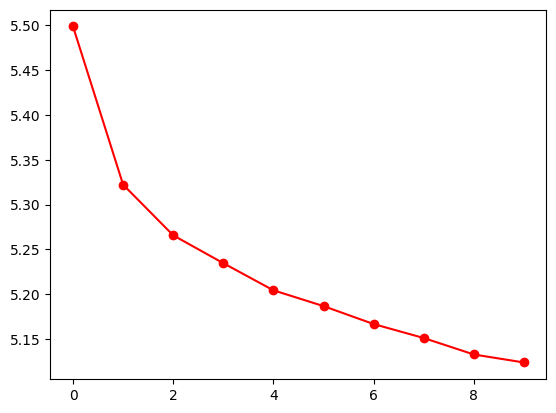

In [18]:
import matplotlib.pyplot as plt

plt.plot(range(num_epochs),  epoch_loss, color='red',  label='Training Loss', marker='o')

In [21]:
from torchinfo import summary

summary(model, input_size=(256, 3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
SimCLR                                        [256, 128]                --
├─Sequential: 1-1                             [256, 512, 1, 1]          --
│    └─Conv2d: 2-1                            [256, 64, 112, 112]       9,408
│    └─BatchNorm2d: 2-2                       [256, 64, 112, 112]       128
│    └─ReLU: 2-3                              [256, 64, 112, 112]       --
│    └─MaxPool2d: 2-4                         [256, 64, 56, 56]         --
│    └─Sequential: 2-5                        [256, 64, 56, 56]         --
│    │    └─BasicBlock: 3-1                   [256, 64, 56, 56]         73,984
│    │    └─BasicBlock: 3-2                   [256, 64, 56, 56]         73,984
│    └─Sequential: 2-6                        [256, 128, 28, 28]        --
│    │    └─BasicBlock: 3-3                   [256, 128, 28, 28]        230,144
│    │    └─BasicBlock: 3-4                   [256, 128, 28, 28]        295,42